# OMNI Data Preprocess

## Data Description
Let's limit our analysis at the moment to the OMNI low res and high res output datasets, which contain measurements from ACE, WIND, IMP8, and Geotail spacecraft.

All of the data are in the high res set are averaged at 5 min intervals, which is quite a bit of data and difficult to work with given that most other datasets are given hourly. If we are able to compute 5 minute external field coefficients, then maybe we'll return to this dataset, but for now we will focus (as others have done) mostly on the hourly data. The hourly data are more likely to be production ready anyway, since 5 minute data feeds (to my knowledge) are unavailable, making this resolution unnecessary. 

For all vector quantities, we take the GSM coordinate system, which is most convenient for studying the effect of the measured magnetic field on Earth's magnetosphere and ionosphere. The X-direction is along the Earth-Sun ray, positive towards the sun. Z-direction is projection of Earth's dipole axis on the plane perpendicular to the X-direction, positive with magnetic North. The Y-direction completes the orthogonal left-handed coordinate system.

### Data columns
The data columns are described in detail [here](https://omniweb.gsfc.nasa.gov/html/HROdocum.html#4b) and [here](https://omniweb.gsfc.nasa.gov/html/ow_data.html#Availability). The hourly data currently of interest in our quest for prediction of Earth's magnetic response to space weather are
- IMF (interplanetary magnetic field)
- Solar wind speed
- Proton density (combined with wind speed, these form a dynamic pressure term)
- Alpha-Proton Density ratio (related and often used as an index for Interplanetary Coronal Mass Ejections, ICME)
- Sunspot number
- f10.7 solar index (strong indicator of solar activity, tracks frequencies originating in solar chromosphere and corona)

The data that we use are from 1998-2017, due to the excellent coverage and consistency from satellite measurements.

In [2]:
# general
import numpy as np
from sklearn import preprocessing
import os
import pdb
import datetime as dt
import warnings

# deep learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

# file management, io
import pandas as pd
import h5py

# plotting
import matplotlib.pyplot as plt
import seaborn as sb

Using TensorFlow backend.


## Load Data

Let's load the data in, which might require creating new hdf files.

### Create HDF files

**Note that we only run the following cells if the hdf files have not yet been created.**

HDF is way faster than other file formats, so we'll always work with these files for our purposes.

The low-res data are in one spreadsheet, which we load in below using pandas and save to an hdf file.

We'll also want to change the time to a python datetime, which requires converting yyyy-doy to a float using the function below.

In [3]:
# check for existence of hdf file
fl = []
fls = os.listdir('../OMNI_data')
for s in fls:
    fl.append('omni_hourly_1998-2017.h5' == s)
    
# only if file doesn't exist, create it
if not any(fl):
    # load excel spreadsheet
    omni_lr_xls = pd.ExcelFile('../OMNI_data/omni_hourly_1998-2017.xlsx')
    omni_lr = pd.read_excel(omni_lr_xls)

    # function for transforming OMNI times to fractional ordinal python datetimes
    #
    # IN: time_data (integer array): with year, doy, hour, and minute in the 
    #      columns
    # OUT: t (flaot array): vector of ordinal dates 
    #
    def OMNI2python_date(time_data):
        nt = time_data.shape[0]
        t = np.zeros((nt,1))
        for ii in range(nt):
            curdate = dt.datetime(int(time_data[ii,0]),1,1).toordinal()
            curfrac =  dt.timedelta(days=time_data[ii,1]-1, \
                             hours=time_data[ii,2], \
                             minutes=time_data[ii,3])/dt.timedelta(1)
            t[ii] = curdate+curfrac
        return t

    # since the data is hourly, we add a vector of zeros for the minutes
    tOMNI = np.concatenate((omni_lr[['Year','DOY','Hour']].values, \
                            np.zeros((omni_lr.shape[0],1))),axis=1)
    t = OMNI2python_date(tOMNI)

    # add python time
    omni_lr = omni_lr.join(pd.Series(t[:,0],name='python time'))
    # reorder columns
    cols = omni_lr.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    omni_lr = omni_lr[cols]

    # save as hdf
    omni_lr.to_hdf('../OMNI_data/omni_hourly_1998-2017.h5','data')

### Read HDF files

Here we actually load data from the HDF5 files.

In [4]:
# load hdf file
omni_lr = pd.read_hdf('../OMNI_data/omni_hourly_1998-2017.h5')
# let's ignore the values from 2018 (just from January 1st)
omni_lr = omni_lr[omni_lr['Year'] != 2018]

# now split up data
yr = omni_lr['Year'].values
yr_unique = np.unique(yr)
nyr = len(yr_unique)
t = omni_lr['python time'].values
# predictors
X = omni_lr[['Bx, GSM (nT)', \
             'By, GSM (nT)', \
             'Bz, GSM (nT)', \
             'SW proton density (N/cm^3)', \
             'SW plasma speed (km/s)', \
             'SW plasma temp (K)', \
             'alpha/proton ratio', \
             'sunspot number', \
             'f10.7 index', \
             'lyman alpha index', \
             'proton flux >1 Mev', \
             'proton flux >2 Mev', \
             'proton flux >4 Mev', \
             'proton flux >10 Mev', \
             'proton flux >30 Mev', \
             'proton flux >60 Mev']].values
# concise feature names
feat = ['Bx', 'By', 'Bz', 'SW proton density', 'SW speed', 'SW temp', \
        'alpha/proton ratio', 'sunspot no.', 'f10.7 index', 'lyman alpha index', \
        'proton >1 Mev', 'proton >2 Mev', 'proton >4 Mev', 'proton >10 Mev', \
        'proton >30 Mev', 'proton >60 Mev']
nfeat = X.shape[1]
# targets (Dst for now)
Y = omni_lr['Dst index (nT)'].values

## Gap filling with Neural Networks

The next step is to provide a simple proof of concept by filling gaps with a neural network trained on the available data. By doing so, I will gain familiarity with *tensorflow* & *pytorch* and provide a complete dataset that can be used in many other neural architectures.

Some of the data have no gaps, which is nice: **sunspot number**, **Lyman-$\alpha$ index**, and the target **D$_{st}$ index** have no gaps.

The other data are all missing fewer than 1% of their data, except the alpha/proton ratios and proton fluxes. The alpha/proton ratios are missing 30% of the data during the period from 1998-2017. Coverage improves towards the end of the series, so it might be possible to incorporate as a predictor, but for now we will be forced to ignore these measurements. The proton fluxes above 10 Mev also improve in coverage for more recent years, possibly allowing us to incorporate them for some training, but all of fluxes with lower thresholds are unusable.

In [5]:
# list gaps by year for each variable and total at end
nanvals = np.max(X,axis=0)
# replace nanval for sunspots and lyman alpha index; no missing data there
nanvals[[7,9]] = 999.9

gaps_year = np.zeros((nyr,nfeat))
gaps_total = np.zeros((1,nfeat))

for jj in range(nfeat):
    for ii in range(nyr):
        # gap percent
        gaps_year[ii,jj] = np.sum(X[yr==yr_unique[ii],jj] == nanvals[jj])/ \
            np.sum(yr==yr_unique[ii]) * 100
    gaps_total[0,jj] = np.sum(X[:,jj] == nanvals[jj])/X.shape[0] * 100
        
gaps = pd.DataFrame(gaps_year,index=yr_unique,columns=feat)
gaps = gaps.append(pd.DataFrame(gaps_total,columns=feat,index=['Total']))

gaps

,Bx,By,Bz,SW proton density,SW speed,SW temp,alpha/proton ratio,sunspot no.,f10.7 index,lyman alpha index,proton >1 Mev,proton >2 Mev,proton >4 Mev,proton >10 Mev,proton >30 Mev,proton >60 Mev
1998,0.022831,0.022831,0.022831,0.490868,0.376712,0.490868,48.127854,0.0,0.000000,0.0,9.018265,9.018265,9.029680,9.029680,9.075342,9.075342
1999,0.273973,0.273973,0.273973,2.020548,0.331050,2.009132,72.511416,0.0,0.000000,0.0,14.075342,14.075342,14.075342,14.075342,14.075342,14.075342
2000,0.000000,0.000000,0.000000,0.671676,0.022769,0.671676,91.029144,0.0,0.000000,0.0,15.186703,15.186703,15.186703,15.186703,15.186703,15.198087
2001,0.000000,0.000000,0.000000,2.168950,0.228311,2.168950,87.865297,0.0,0.000000,0.0,35.285388,35.285388,35.285388,35.285388,35.285388,35.296804
2002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.748858,0.0,0.000000,0.0,60.764840,60.787671,60.787671,60.810502,61.004566,61.050228
2003,0.000000,0.000000,0.000000,1.484018,0.821918,1.369863,40.479452,0.0,0.000000,0.0,84.634703,84.646119,84.646119,84.657534,84.680365,84.714612
2004,0.000000,0.000000,0.000000,0.944900,0.034153,0.922131,34.380692,0.0,0.000000,0.0,53.369763,53.392532,53.392532,53.449454,53.483607,53.517760
2005,0.000000,0.000000,0.000000,0.399543,0.319635,0.376712,6.335616,0.0,0.000000,0.0,54.143836,54.143836,54.143836,54.143836,54.178082,54.200913
2006,0.000000,0.000000,0.000000,0.570776,0.000000,0.479452,14.098174,0.0,0.000000,0.0,100.000000,100.000000,100.000000,0.114155,0.114155,0.114155
2007,0.000000,0.000000,0.000000,0.502283,0.000000,0.445205,8.515982,0.0,0.000000,0.0,100.000000,100.000000,100.000000,0.308219,0.308219,0.308219


Here, we just ignore the data with gaps.

In [6]:
idx = np.array([0, 1, 2, 3, 4, 5, 7, 8, 9], dtype=int)
X = X[:,idx]
feat = [feat[i] for i in idx]

## Check Linear Independence

Let's check the linear dependencies of the preditive variables. Ideally, our variables are linearly independent and thereby contribute unique information about the state of solar forcing of Earth's magnetic field. After inspecting the extent of dependencies, we can prewhiten the time series 

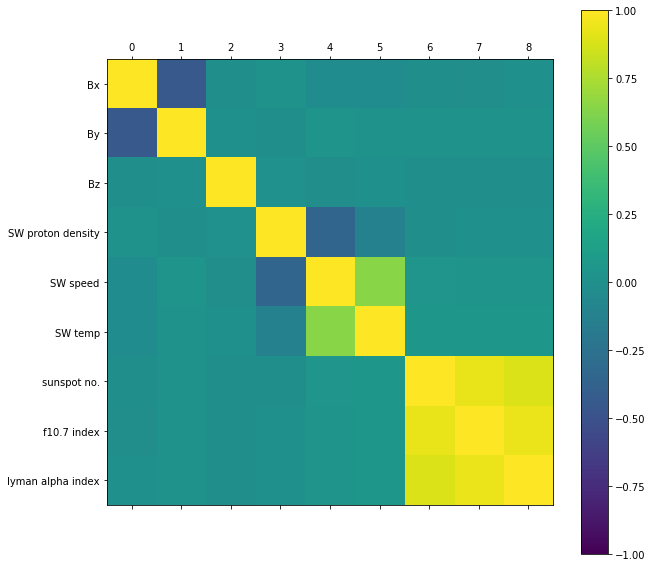

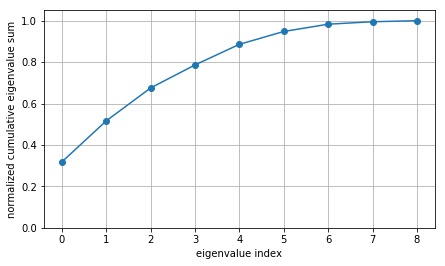

In [8]:
# compute correlations between variables
Xcor = X.copy()
for ii in range(X.shape[1]):
    Xcor[X[:,ii] == nanvals[ii],ii] = np.mean(Xcor[:,ii])
cor = np.corrcoef(Xcor.T)

# compute eigenvalues
e = np.linalg.eig(cor)[0]
e = np.sort(e)[::-1]

# plot
fig, ax = plt.subplots(figsize=(10,10))
corplt = ax.matshow(cor)
ax.set_yticks(range(0,9))
ax.set_yticklabels(feat)
plt.colorbar(corplt)
corplt.set_clim(-1,1)
plt.show()


plt.figure(figsize=(7,4))
plt.plot(np.cumsum(e)/np.sum(e),'o-')
plt.xlabel('eigenvalue index')
plt.ylabel('normalized cumulative eigenvalue sum')
plt.grid(True)
plt.ylim(0,1.05)
plt.show()


Let's proceed by leveraging the fact that we have measurements of multiple datasets simultaneously. The fewest gaps occur in the measurements of the sunspot count, followed by the interplanetary magnetic field. We can use the simultaneous observed measurements of the IMF to predict the missing values. Then, once we have those missing values, we can move onto the next series with the fewest gaps, which is the f10.7 series. We can use the simultaneous measurements of the IMF, sunspot count, and the observed f10.7 measurements to predict the missing values of the f10.7 series. We progress like this through the remaining features, which are the solar wind (SW) speed and the proton density, in each step adding variables to the prediction.

### IMF gaps

Let's start with the IMF data. We can use uninterrupted sequences of the IMF data to predict the values in the gaps. To this end, we will need to identify gaps in the data and isolate continuous sequences of data that we can split into training, validation, and testing datasets.

To work with these deep learning frameworks, we'll split the data up into batches

#### LSTM architecture

To gain familiarity with the implementation of neural networks in python, let's start with a simple LSTM architecture.

##### Helper Functions

In [9]:
# Find sequences of a given value within an input vector. 
#
# IN:
# x: vector of values in which to find sequences
# val: scalar value to find sequences of in x
# noteq: (false) whether to find sequences equal or not equal to the supplied
#    value
#
# OUT:
# idx: array that contains in rows the number of total sequences of val, with 
#   the first column containing the begin indices of each sequence, the second 
#   column containing the end indices of sequences, and the third column 
#   contains the length of the sequence.
def findseq(x,val,noteq=False):
    x = x.copy().squeeze()
    assert len(x.shape) == 1, "x must be vector"
    # indices of value in x, and
    # compute differences of x, since subsequent occurences of val in x will 
    # produce zeros after differencing. append nonzero value at end to make 
    # x and difx the same size
    if noteq:
        validx = np.argwhere(x != val).squeeze()
        x[validx] = val+1
        difx = np.append(np.diff(x),1)
    else:
        validx = np.argwhere(x == val).squeeze()
        difx = np.append(np.diff(x),1)
    nval = len(validx)
    # if val not in x, warn user
    if nval == 0:
        warnings.warn("value val not found in x")
        return 0
    
    # now, where validx is one and difx is zero, we know that we have 
    # neighboring values of val in x. Where validx is one and difx is nonzero, 
    # we have end of a sequence
    
    # now loop over all occurrences of val in x and construct idx
    c1 = 0
    idx = np.empty((1,3))
    while c1 < nval:
        curidx = np.array([[validx[c1],validx[c1],1]])
        c2 = 0
        while difx[validx[c1]+c2] == 0:
            curidx[0,1] += 1
            curidx[0,2] += 1
            c2 += 1
        idx = np.append(idx,curidx,axis=0)
        c1 = c1+c2+1
    idx = idx[1:,:].astype(int)
    return idx


# depending on batch size and gaps in data, construct batches
#
# IN: 
#  data: nd-array of data with shape (nobs, nfeatures)
#  dataidx: nd-array of beginning and end indices of data sequences in data with
#   shape (nsequences,3) and columns (beg index, end index, length of sequence)
#  batch_size: integer of batch size to split data into
#
# OUT:
#  batches: nd-array with size (nbatches*batch_size, 1, nfeatures), as required
#   by keras; a more intuitive shape would be (nbatches, batch_size, nfeatures)
#
def getbatches(data,dataidx, batch_size):
    assert dataidx.shape[1] == 3, 'dataidx must be correct shape'
    assert batch_size < np.max(dataidx[:,2]), \
         'at least one data sequence must be long enough for given batch_size'
    nseq = dataidx.shape[0]
    nfeatures = data.shape[1]
    # within each interval of data, split into largest possible number of 
    # batches with length batch_size
    X = np.zeros((batch_size, nfeatures))
    for ii in range(nseq):
        # skip this sequence if it is too short
        if dataidx[ii,2] < batch_size:
            continue
        nbatch = np.floor(dataidx[ii,2]/batch_size)
        curidx = np.arange(dataidx[ii,0],dataidx[ii,0]+int(nbatch*batch_size))
        curdat = data[curidx,:].reshape((int(nbatch*batch_size), nfeatures))
        X = np.append(X, curdat, axis=0)
    # remove first batch_size zeros at beginning
    X = X[batch_size:,:]
    return X


# From a data array with observations in rows and features in columns, split 
# split into testing and training data based on which rows to use (datain_idx), 
# batch_sizes, which features for prediction (incols) and which features as 
# targest (outcols). Since we're concerned with time series forecasting, the 
# number of steps to forecast ahead is lahead.
#
# IN:
#
# OUT:
#
def datasplit(data, datain_idx, batch_size, incols, outcols, \
              train_percent=0.8, lahead=1):
    nfeatin = len(incols)
    dataout_idx = datain_idx.copy()
    dataout_idx[:,0] = dataout_idx[:,0]+lahead
    dataout_idx[:,2] = dataout_idx[:,2]-lahead
    dat_in = getbatches(data[:,incols], 
                        datain_idx, 
                        batch_size).reshape(-1,1,nfeatin)
    dat_out = getbatches(data[:,outcols], 
                         dataout_idx, batch_size)
    nbatch = dat_in.shape[0]/batch_size
    # now construct training and testing sets
    trainbatch = np.random.permutation(int(nbatch))[0:int(0.8*nbatch)]
    trainidx = np.zeros(dat_in.shape[0],dtype=bool)
    for ii in range(trainbatch.shape[0]):
        curidx = np.arange(trainbatch[ii]*batch_size, \
                           trainbatch[ii]*batch_size+batch_size)
        trainidx[curidx] = True
    testidx  = np.logical_not(trainidx)
    
    dat_in_train = dat_in[trainidx,:,:]
    dat_out_train = dat_out[trainidx,:]
    dat_in_test = dat_in[testidx,:,:]
    dat_out_test = dat_out[testidx,:]
    return dat_in_train, dat_out_train, dat_in_test, dat_out_test

Now apply to the IMF data

In [10]:
# we want network to predict next value
lahead = 1
# let's work with batches
batch_size = 1000 # in hours
# indices of uninterrupted data sequences
datain_idx = findseq(X[:,1],nanvals[1],noteq=True)

# subsequent batches, let's use Bx, By, Bz, sunspots, and lyman alpha as input
incols = [0,1,2,6,8]
nfeatin = len(incols)
outcols = [0,1,2]
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)

# scale outputs
#mu = np.mean(dat_in_train, axis=0)
#std = np.std(dat_in_train, axis=0)
#dat_in_train = (dat_in_train-mu)/std
#dat_in_test = (dat_in_test-mu)/std
#dat_out_train = (dat_out_train-mu[0,0:nfeatout])/std[0,0:nfeatout]
#dat_out_test = (dat_out_test-mu[0,0:nfeatout])/std[0,0:nfeatout]

# recurrent architecture, create input and output datasets
rnn = Sequential()
rnn.add(LSTM(400, 
        name='LSTM_1',
        stateful=False,
        input_shape=(1,nfeatin),
        batch_size=batch_size,
        return_sequences=False,
        activation='relu'))
rnn.add(Dense(nfeatout,
              name='Dense'))
opt = keras.optimizers.RMSprop()
rnn.compile(loss='mse',optimizer=opt)

# fit model
hist = rnn.fit(dat_in_train,
        dat_out_train,
        epochs=50,
        batch_size=batch_size,
        shuffle=False,
        verbose=1)

# evaluate on test data
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

Epoch 1/50
138000/138000 [==============================] - 3s 22us/step - loss: 5.5270
Epoch 2/50
138000/138000 [==============================] - 1s 5us/step - loss: 4.2020
Epoch 3/50
138000/138000 [==============================] - 1s 5us/step - loss: 4.0823
Epoch 4/50
138000/138000 [==============================] - 1s 5us/step - loss: 4.0179
Epoch 5/50
138000/138000 [==============================] - 1s 5us/step - loss: 3.9697
Epoch 6/50
138000/138000 [==============================] - 1s 5us/step - loss: 3.9398
Epoch 7/50
138000/138000 [==============================] - 1s 5us/step - loss: 3.9110
Epoch 8/50
138000/138000 [==============================] - 1s 5us/step - loss: 3.8961
Epoch 9/50
138000/138000 [==============================] - 1s 5us/step - loss: 3.8761
Epoch 10/50
138000/138000 [==============================] - 1s 5us/step - loss: 3.8674
Epoch 11/50
138000/138000 [==============================] - 1s 5us/step - loss: 3.8567
Epoch 12/50
138000/138000 [=============

0.7496397756407759


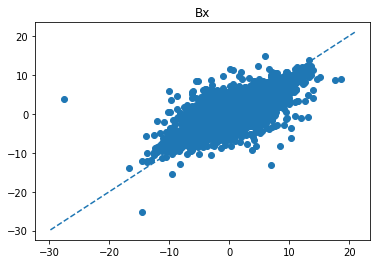

0.732347055172548


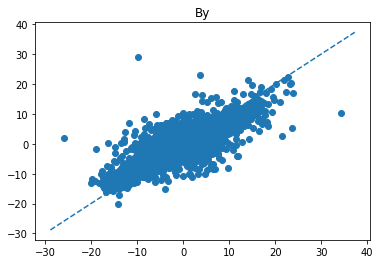

0.5016857837799289


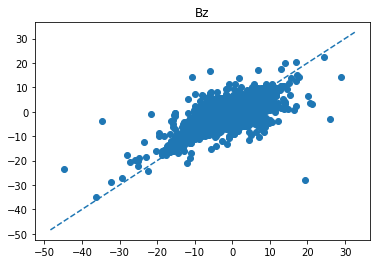

In [24]:
rnn.reset_states()
dat_pred = rnn.predict(dat_in_test,batch_size=batch_size)
for ii in range(nfeatout):
    plt.figure()
    print(np.corrcoef(dat_out_test[:,ii],dat_pred[:,ii])[0,1]**2)
    plt.scatter(dat_out_test[:,ii],dat_pred[:,ii])
    #sb.kdeplot(dat_out_test[:,ii].squeeze(),
    #           dat_pred[:,ii].squeeze(),
    #           n_levels=10)
    abline(1,0)
    plt.title(feat[outcols[ii]])
    plt.show()

# use network to fill gaps in IMF data
gapidx = findseq(X[:,1],nanvals[1])
ngaps = gapidx.shape[0]
Xgapsfilled = X.copy()
for ii in range(ngaps):
    curgap = gapidx[ii,2]
    for jj in range(curgap):
        cur_in = Xgapsfilled[gapidx[ii,0]+jj-batch_size:gapidx[ii,0]+jj,incols]
        cur_in = cur_in.reshape(-1,1,nfeatin)
        rnn.reset_states()
        cur_pred = rnn.predict(cur_in,batch_size=batch_size)
        Xgapsfilled[gapidx[ii,0]+jj,outcols] = cur_pred[-1,:]

Now again to the f10.7 data.

Epoch 1/50
136000/136000 [==============================] - 2s 13us/step - loss: 1193.3726
Epoch 2/50
136000/136000 [==============================] - 1s 6us/step - loss: 12.5696
Epoch 3/50
136000/136000 [==============================] - 1s 6us/step - loss: 10.1309
Epoch 4/50
136000/136000 [==============================] - 1s 6us/step - loss: 9.1016
Epoch 5/50
136000/136000 [==============================] - 1s 6us/step - loss: 9.9147
Epoch 6/50
136000/136000 [==============================] - 1s 6us/step - loss: 9.3351
Epoch 7/50
136000/136000 [==============================] - 1s 6us/step - loss: 9.0960
Epoch 8/50
136000/136000 [==============================] - 1s 6us/step - loss: 8.4372
Epoch 9/50
136000/136000 [==============================] - 1s 6us/step - loss: 8.0100
Epoch 10/50
136000/136000 [==============================] - 1s 6us/step - loss: 7.7644
Epoch 11/50
136000/136000 [==============================] - 1s 6us/step - loss: 7.5547
Epoch 12/50
136000/136000 [========

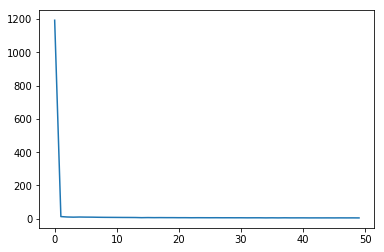

In [42]:
# indices of uninterrupted data sequences
datain_idx = findseq(X[:,7],nanvals[7],noteq=True)

lahead = 1
batch_size = 1000

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, and previous f10.7 as input
incols = [0,1,2,6,7,8]
nfeatin = len(incols)
outcols = [7]
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)
        
# RNN
rnn = Sequential()
rnn.add(LSTM(400, 
        name='LSTM_1',
        stateful=False,
        input_shape=(1,nfeatin),
        batch_size=batch_size,
        return_sequences=False,
        activation='relu'))
rnn.add(Dense(nfeatout,
              name='Dense'))
rnn.compile(loss='mse',optimizer=opt)

# fit model
hist = rnn.fit(dat_in_train,
        dat_out_train,
        epochs=50,
        batch_size=batch_size,
        shuffle=False,
        verbose=1)
plt.plot(hist.history['loss'])

0.9981645790316773


C:\Users\Adrian\.julia\packages\Conda\m7vem\deps\usr\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


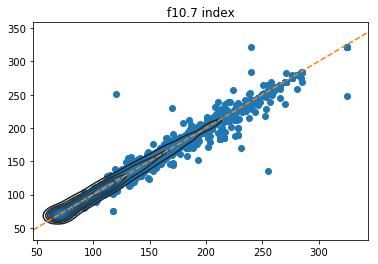

In [43]:
# evaluate
rnn.reset_states()
dat_pred = rnn.predict(dat_in_test,batch_size=batch_size)

for ii in range(nfeatout):
    print(np.corrcoef(dat_out_test[:,ii],dat_pred[:,ii])[0,1]**2)
    plt.scatter(dat_out_test[:,ii],dat_pred[:,ii])
    sb.kdeplot(dat_out_test[:,ii].squeeze(),
               dat_pred[:,ii].squeeze(),
               n_levels=10)
    abline(1,0)
    plt.title(feat[outcols[ii]])

gapidx = findseq(X[:,7],nanvals[7])
ngaps = gapidx.shape[0]

for ii in range(ngaps):
    curgap = gapidx[ii,2]
    for jj in range(curgap):
        cur_in = Xgapsfilled[gapidx[ii,0]+jj-batch_size:gapidx[ii,0]+jj,incols]
        cur_in = cur_in.reshape(-1,1,nfeatin)
        rnn.reset_states()
        cur_pred = rnn.predict(cur_in,batch_size=batch_size)
        Xgapsfilled[gapidx[ii,0]+jj,outcols] = cur_pred[-1,:]

Next is solar wind speed

Epoch 1/50
133000/133000 [==============================] - 2s 14us/step - loss: 37694.1492
Epoch 2/50
133000/133000 [==============================] - 1s 6us/step - loss: 329.4292
Epoch 3/50
133000/133000 [==============================] - 1s 6us/step - loss: 236.2983
Epoch 4/50
133000/133000 [==============================] - 1s 6us/step - loss: 223.6098
Epoch 5/50
133000/133000 [==============================] - 1s 6us/step - loss: 217.5065
Epoch 6/50
133000/133000 [==============================] - 1s 6us/step - loss: 211.0332
Epoch 7/50
133000/133000 [==============================] - 1s 6us/step - loss: 206.6479
Epoch 8/50
133000/133000 [==============================] - 1s 6us/step - loss: 202.7828
Epoch 9/50
133000/133000 [==============================] - 1s 6us/step - loss: 199.9334
Epoch 10/50
133000/133000 [==============================] - 1s 6us/step - loss: 197.1787
Epoch 11/50
133000/133000 [==============================] - 1s 6us/step - loss: 194.9849
Epoch 12/50
1330

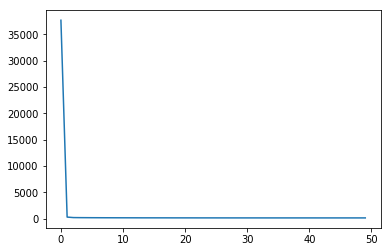

In [57]:
# indices of uninterrupted data sequences
datain_idx = findseq(X[:,4],nanvals[4],noteq=True)

lahead = 1
batch_size = 1000

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, and previous f10.7 as input
incols = [0,1,2,4,6,7,8]
nfeatin = len(incols)
outcols = [4]
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)
        
# RNN
rnn = Sequential()
rnn.add(LSTM(400, 
        name='LSTM_1',
        stateful=False,
        input_shape=(1,nfeatin),
        batch_size=batch_size,
        return_sequences=False,
        activation='relu'))
rnn.add(Dense(nfeatout,
              name='Dense'))
rnn.compile(loss='mse',optimizer=opt)

# fit model
hist = rnn.fit(dat_in_train,
        dat_out_train,
        epochs=50,
        batch_size=batch_size,
        shuffle=False,
        verbose=1)
plt.plot(hist.history['loss'])

0.9863108737681484


C:\Users\Adrian\.julia\packages\Conda\m7vem\deps\usr\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


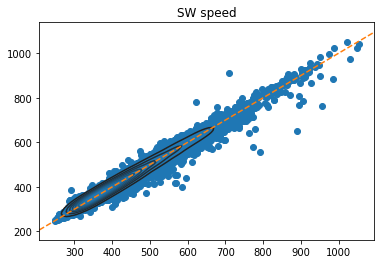

In [59]:
# evaluate
rnn.reset_states()
dat_pred = rnn.predict(dat_in_test,batch_size=batch_size)

for ii in range(nfeatout):
    print(np.corrcoef(dat_out_test[:,ii],dat_pred[:,ii])[0,1]**2)
    plt.scatter(dat_out_test[:,ii],dat_pred[:,ii])
    sb.kdeplot(dat_out_test[:,ii].squeeze(),
               dat_pred[:,ii].squeeze(),
               n_levels=10)
    abline(1,0)
    plt.title(feat[outcols[ii]])

In [101]:
gapidx = findseq(X[:,4],nanvals[4])
ngaps = gapidx.shape[0]

for ii in range(ngaps):
    curgap = gapidx[ii,2]
    # if gap occurs before batch_size samples, jsut linearly interpolate
    if gapidx[ii,0] < batch_size:
        tcur = np.concatenate((t[0:gapidx[ii,0]],t[gapidx[ii,1]+1:gapidx[ii,1]+100]))
        tquery = t[gapidx[ii,0]:gapidx[ii,1]+1]
        Xcur = np.concatenate((X[0:gapidx[ii,0],outcols], \
                               X[gapidx[ii,1]+1:gapidx[ii,1]+100,outcols]),axis=0).squeeze()
        Xgapsfilled[gapidx[ii,0]:gapidx[ii,1],outcols] = np.interp(tquery, tcur, Xcur)
    else:
        for jj in range(curgap):
            cur_in = Xgapsfilled[gapidx[ii,0]+jj-batch_size:gapidx[ii,0]+jj,incols]
            cur_in = cur_in.reshape(-1,1,nfeatin)
            rnn.reset_states()
            cur_pred = rnn.predict(cur_in,batch_size=batch_size)
            Xgapsfilled[gapidx[ii,0]+jj,outcols] = cur_pred[-1,:]

Then solar wind temperature.

Epoch 1/50
110000/110000 [==============================] - 2s 17us/step - loss: 8215691583.4182
Epoch 2/50
110000/110000 [==============================] - 1s 6us/step - loss: 1317880303.4182
Epoch 3/50
110000/110000 [==============================] - 1s 6us/step - loss: 1283851652.6545
Epoch 4/50
110000/110000 [==============================] - 1s 6us/step - loss: 1281305215.4182
Epoch 5/50
110000/110000 [==============================] - 1s 6us/step - loss: 1278903088.4364
Epoch 6/50
110000/110000 [==============================] - 1s 6us/step - loss: 1276644012.6545
Epoch 7/50
110000/110000 [==============================] - 1s 6us/step - loss: 1274528515.0545
Epoch 8/50
110000/110000 [==============================] - 1s 6us/step - loss: 1272557786.0364
Epoch 9/50
110000/110000 [==============================] - 1s 6us/step - loss: 1270733769.6000
Epoch 10/50
110000/110000 [==============================] - 1s 6us/step - loss: 1269058072.2909
Epoch 11/50
110000/110000 [===========

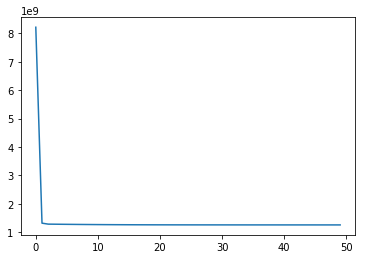

In [102]:
# indices of uninterrupted data sequences
datain_idx = findseq(X[:,5],nanvals[5],noteq=True)

lahead = 1
batch_size = 1000

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, and previous f10.7 as input
incols = [0,1,2,4,5,6,7,8]
nfeatin = len(incols)
outcols = [5]
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)
        
# RNN
rnn = Sequential()
rnn.add(LSTM(400, 
        name='LSTM_1',
        stateful=False,
        input_shape=(1,nfeatin),
        batch_size=batch_size,
        return_sequences=False,
        activation='relu'))
rnn.add(Dense(nfeatout,
              name='Dense'))
rnn.compile(loss='mse',optimizer=opt)

# fit model
hist = rnn.fit(dat_in_train,
        dat_out_train,
        epochs=50,
        batch_size=batch_size,
        shuffle=False,
        verbose=1)
plt.plot(hist.history['loss'])

0.8905802828174879


C:\Users\Adrian\.julia\packages\Conda\m7vem\deps\usr\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


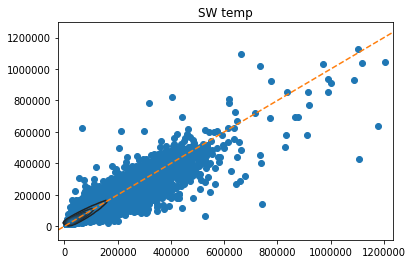

In [103]:
# evaluate
rnn.reset_states()
dat_pred = rnn.predict(dat_in_test,batch_size=batch_size)

for ii in range(nfeatout):
    print(np.corrcoef(dat_out_test[:,ii],dat_pred[:,ii])[0,1]**2)
    plt.scatter(dat_out_test[:,ii],dat_pred[:,ii])
    sb.kdeplot(dat_out_test[:,ii].squeeze(),
               dat_pred[:,ii].squeeze(),
               n_levels=10)
    abline(1,0)
    plt.title(feat[outcols[ii]])

In [104]:
gapidx = findseq(X[:,5],nanvals[5])
ngaps = gapidx.shape[0]

for ii in range(ngaps):
    curgap = gapidx[ii,2]
    # if gap occurs before batch_size samples, jsut linearly interpolate
    if gapidx[ii,0] < batch_size:
        tcur = np.concatenate((t[0:gapidx[ii,0]],t[gapidx[ii,1]+1:gapidx[ii,1]+100]))
        tquery = t[gapidx[ii,0]:gapidx[ii,1]+1]
        Xcur = np.concatenate((X[0:gapidx[ii,0],outcols], \
                               X[gapidx[ii,1]+1:gapidx[ii,1]+100,outcols]),axis=0).squeeze()
        Xgapsfilled[gapidx[ii,0]:gapidx[ii,1],outcols] = np.interp(tquery, tcur, Xcur)
    else:
        for jj in range(curgap):
            cur_in = Xgapsfilled[gapidx[ii,0]+jj-batch_size:gapidx[ii,0]+jj,incols]
            cur_in = cur_in.reshape(-1,1,nfeatin)
            rnn.reset_states()
            cur_pred = rnn.predict(cur_in,batch_size=batch_size)
            Xgapsfilled[gapidx[ii,0]+jj,outcols] = cur_pred[-1,:]

Finally, SW proton density.

Epoch 1/200
101000/101000 [==============================] - 2s 19us/step - loss: 101527.0667
Epoch 2/200
101000/101000 [==============================] - 1s 6us/step - loss: 84966.1505
Epoch 3/200
101000/101000 [==============================] - 1s 6us/step - loss: 88159.0514
Epoch 4/200
101000/101000 [==============================] - 1s 6us/step - loss: 80634.4841
Epoch 5/200
101000/101000 [==============================] - 1s 6us/step - loss: 74330.6888
Epoch 6/200
101000/101000 [==============================] - 1s 6us/step - loss: 79246.1456
Epoch 7/200
101000/101000 [==============================] - 1s 6us/step - loss: 63188.1294
Epoch 8/200
101000/101000 [==============================] - 1s 6us/step - loss: 58625.9887
Epoch 9/200
101000/101000 [==============================] - 1s 6us/step - loss: 62895.5012
Epoch 10/200
101000/101000 [==============================] - 1s 6us/step - loss: 56292.0534
Epoch 11/200
101000/101000 [==============================] - 1s 6us/step - l

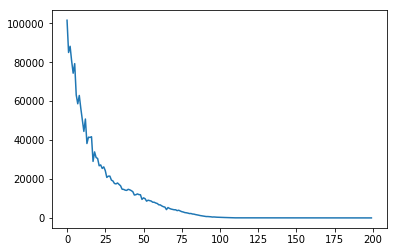

In [113]:
# indices of uninterrupted data sequences
datain_idx = findseq(X[:,3],nanvals[3],noteq=True)

lahead = 1
batch_size = 1000

# subsequent batches, let's use Bx, By, Bz, sunspots, lyman alpha, and previous f10.7 as input
incols = [0,1,2,3,4,5,6,7,8]
nfeatin = len(incols)
outcols = [3]
nfeatout = len(outcols)
dat_in_train, dat_out_train, dat_in_test, dat_out_test = \
        datasplit(X,
              datain_idx,
              batch_size,
              incols,
              outcols,
              train_percent=0.8,
              lahead=lahead)
        
# RNN
rnn = Sequential()
rnn.add(LSTM(400, 
        name='LSTM_1',
        stateful=False,
        input_shape=(1,nfeatin),
        batch_size=batch_size,
        return_sequences=False,
        activation='relu'))
rnn.add(Dense(nfeatout,
              name='Dense'))
rnn.compile(loss='mse',optimizer=opt)

# fit model
hist = rnn.fit(dat_in_train,
        dat_out_train,
        epochs=200,
        batch_size=batch_size,
        shuffle=False,
        verbose=1)
plt.plot(hist.history['loss'])

0.5185129017000495


C:\Users\Adrian\.julia\packages\Conda\m7vem\deps\usr\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


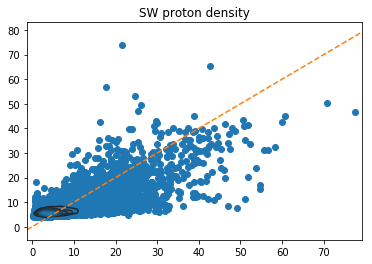

In [114]:
# evaluate
rnn.reset_states()
dat_pred = rnn.predict(dat_in_test,batch_size=batch_size)

for ii in range(nfeatout):
    print(np.corrcoef(dat_out_test[:,ii],dat_pred[:,ii])[0,1]**2)
    plt.scatter(dat_out_test[:,ii],dat_pred[:,ii])
    sb.kdeplot(dat_out_test[:,ii].squeeze(),
               dat_pred[:,ii].squeeze(),
               n_levels=10)
    abline(1,0)
    plt.title(feat[outcols[ii]])

In [115]:
gapidx = findseq(X[:,3],nanvals[3])
ngaps = gapidx.shape[0]

for ii in range(ngaps):
    curgap = gapidx[ii,2]
    # if gap occurs before batch_size samples, jsut linearly interpolate
    if gapidx[ii,0] < batch_size:
        tcur = np.concatenate((t[0:gapidx[ii,0]],t[gapidx[ii,1]+1:gapidx[ii,1]+100]))
        tquery = t[gapidx[ii,0]:gapidx[ii,1]+1]
        Xcur = np.concatenate((X[0:gapidx[ii,0],outcols], \
                               X[gapidx[ii,1]+1:gapidx[ii,1]+100,outcols]),axis=0).squeeze()
        Xgapsfilled[gapidx[ii,0]:gapidx[ii,1],outcols] = np.interp(tquery, tcur, Xcur)
    else:
        for jj in range(curgap):
            cur_in = Xgapsfilled[gapidx[ii,0]+jj-batch_size:gapidx[ii,0]+jj,incols]
            cur_in = cur_in.reshape(-1,1,nfeatin)
            rnn.reset_states()
            cur_pred = rnn.predict(cur_in,batch_size=batch_size)
            Xgapsfilled[gapidx[ii,0]+jj,outcols] = cur_pred[-1,:]